In [1]:
# Run everytime (To connect to drive that contains the .pt file with preprocessed data for 10K games, and to connect to GitHub account)

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.ssh
!cp /content/drive/MyDrive/ML_Sem3_Project/.ssh/id_rsa ~/.ssh/
!cp /content/drive/MyDrive/ML_Sem3_Project/.ssh/id_rsa.pub ~/.ssh/
!chmod 600 ~/.ssh/id_rsa
!ssh-keyscan github.com >> ~/.ssh/known_hosts

import os

repo_dir = "/content/ML_Project_2025"

if not os.path.exists(repo_dir):
  !git clone git@github.com:astroartics/ML_Project_2025.git {repo_dir}
else:
  %cd {repo_dir}
  !git pull

%cd {repo_dir}

Mounted at /content/drive
# github.com:22 SSH-2.0-aae3c6b
# github.com:22 SSH-2.0-aae3c6b
# github.com:22 SSH-2.0-aae3c6b
# github.com:22 SSH-2.0-aae3c6b
# github.com:22 SSH-2.0-aae3c6b
Cloning into '/content/ML_Project_2025'...
remote: Enumerating objects: 194, done.
remote: Total 194 (delta 0), reused 0 (delta 0), pack-reused 194 (from 1)
Receiving objects: 100% (194/194), 1.71 MiB | 1.29 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/ML_Project_2025


In [2]:

# Run everytime (To load variables and data from the .pt file present on drive)

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device, "\n")

checkpoint_path = "/content/drive/MyDrive/ML_Sem3_Project/preprocessed_data.pt"
checkpoint = torch.load(
    checkpoint_path,
    map_location = device,  # ensures safe loading on CPU/GPU
    weights_only = False
)

# --------------------------------

# 4. Extract Variables
vocab = checkpoint["vocab"]
inv_vocab = checkpoint["inv_vocab"]

# Move tensors to device
X_padded = checkpoint["X_padded"].to(device)  # PyTorch does not run natively on TPU, hence using T4 GPU
y_tensor = checkpoint["y_tensor"].to(device)

# DataFrame cannot move to device; it stays on CPU
data = checkpoint["data"]

print(data["moves"].head())

# --------------------------------

# 5. Status
print("\nLoaded checkpoint successfully.\n")
print("X_padded shape:", X_padded.shape)
print("y_tensor shape:", y_tensor.shape)
print("Example vocab size:", len(vocab))


Using device: cuda 

0    e4 d5 Nf3 dxe4 Ne5 Nf6 d4 exd3 Bxd3 e6 Nc3 Bd6...
1    b4 e5 Bb2 d6 c3 Bf5 d3 Nf6 e4 Bg6 Be2 Be7 Nf3 ...
2    e4 d5 exd5 Qxd5 Nc3 Qa5 Nf3 Nf6 d4 Bg4 Bd2 Nc6...
3    e4 e5 Nf3 Nf6 Nc3 d6 Bc4 Be6 Qe2 Nbd7 d4 Bxc4 ...
4    d4 e6 c4 c6 Nc3 d5 cxd5 cxd5 e4 Nc6 e5 Qb6 Nge...
Name: moves, dtype: object

Loaded checkpoint successfully.

X_padded shape: torch.Size([658379, 292])
y_tensor shape: torch.Size([658379])
Example vocab size: 3672


In [3]:
# Train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y_tensor,
    test_size = 0.2,  # 80-20 split
    random_state = 42,
    shuffle=True
)

X_train.shape, X_test.shape

(torch.Size([526703, 292]), torch.Size([131676, 292]))

In [4]:
# PyTorch Datasets and DataLoaders

# Why these are needed:
'''
1) Data cannot be fed to the model directly, because the number of integers is huge.
2) It must be given to the model in batches.
3) A DataLoader iterates over these batches.
4) DataLoader handles batching, shuffling, and feeding the model (if batch size = 64, then taking 64 sequences for X and 64 labels for y)
5) DataLoader also uses multiple workers to load batches faster.
6) Dataset allows Python to treat the data like a list (shuffling indices, slicing samples, fetching mini-batches automatically)
7) Dataset is a wrapper that tells PyTorch "How to get the ith sample."
8) Dataset: Defines how to access each sample
   DataLoader: Defines how to group examples into batches efficiently during training
'''

from torch.utils.data import Dataset, DataLoader

# X and y are not converted to a new format, they are just wrapped and become accessible through the Dataset interface
# For example, before Dataset, we manually index
# sample_X = X_train[100]
# sample_y = y_train[100]
# but, after Dataset, DataLoader can automatically fetch train_ds[100] -> returns (X_train[100], y_train[100])
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    # Returns one sample to the DataLoader when requested: DataLoader needs data to be wrapped in a Dataset to
    # access it one by one randomly to form batches.
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders

batch_size = 64

train_dataset = ChessDataset(X_train, y_train)
test_dataset  = ChessDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size)

In [5]:
# LSTM

import torch
import torch.nn as nn

# Defining the Baseline LSTM model
# Training time for 5 epochs using a GPU: ~15 minutes

class BaselineLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=1, padding_idx=0):
        super().__init__()
        # Embedding: converts token IDs -> dense vectors
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=padding_idx)
        # LSTM: processes sequence of embeddings
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # Final linear layer to produce logits for each vocabulary token
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: LongTensor of shape (batch_size, seq_len)
        emb = self.embedding(x)                     # -> (batch_size, seq_len, embed_dim)
        outputs, (h_n, c_n) = self.lstm(emb)        # outputs -> (batch_size, seq_len, hidden_dim)
                                                   # h_n -> (num_layers, batch_size, hidden_dim)
        last_hidden = outputs[:, -1, :]             # take output at last time-step -> (batch_size, hidden_dim)
        logits = self.fc(last_hidden)               # -> (batch_size, vocab_size)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)        # vocab from your preprocessing (includes PAD and UNK)
lstm_model = BaselineLSTM(vocab_size=vocab_size, embed_dim=128, hidden_dim=256, num_layers=1, padding_idx=vocab['<PAD>']).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<PAD>'])   # ignore pad index if used in targets (usually not)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5
lstm_train_losses = []

lstm_model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Move to device
        X_batch = X_batch.to(device)                   # (batch_size, seq_len), dtype=torch.long
        y_batch = y_batch.to(device)                   # (batch_size,), dtype=torch.long (class indices)

        optimizer.zero_grad()

        logits = lstm_model(X_batch)                        # (batch_size, vocab_size)
        loss = criterion(logits, y_batch)              # CrossEntropy expects (N, C) and targets (N,)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)    # sum-of-losses for averaging later

    avg_loss = total_loss / len(train_loader.dataset)
    lstm_train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}  Train loss: {avg_loss:.4f}")

# Predicting / decoding one example
lstm_model.eval()
with torch.no_grad():
    sample_X = X_test[0].unsqueeze(0).to(device)      # shape (1, seq_len)
    logits = lstm_model(sample_X)                          # (1, vocab_size)
    pred_id = logits.argmax(dim=-1).item()            # integer token id
    pred_move = inv_vocab[pred_id]                    # decode to SAN using your inv_vocab
    print("Predicted token id:", pred_id, "Predicted SAN:", pred_move)

Epoch 1/5  Train loss: 6.3902
Epoch 2/5  Train loss: 6.3626
Epoch 3/5  Train loss: 6.3594
Epoch 4/5  Train loss: 6.3576
Epoch 5/5  Train loss: 6.3561
Predicted token id: 24 Predicted SAN: O-O


In [6]:
# Transformer
# Training time for 5 epochs using a GPU: ~30 minutes

import math
import torch
import torch.nn as nn

# Since trandformers have no notion of order, we must add positional encoding information
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]

class TransformerBaseline(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
        padding_idx=0,
        max_len=5000
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model,
            padding_idx=padding_idx
        )

        self.positional_encoding = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True   # IMPORTANT: matches your (B, T, D)
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        x: (batch_size, seq_len)
        """

        # Padding mask: True where PAD
        padding_mask = (x == vocab['<PAD>'])

        emb = self.embedding(x)                    # (B, T, D)
        emb = self.positional_encoding(emb)        # (B, T, D)

        out = self.transformer_encoder(
            emb,
            src_key_padding_mask=padding_mask
        )                                           # (B, T, D)

        # Take last non-pad token representation
        lengths = (~padding_mask).sum(dim=1) - 1   # (B,)
        last_hidden = out[torch.arange(out.size(0)), lengths]

        logits = self.fc(last_hidden)               # (B, vocab_size)
        return logits

# Instantiating model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_model = TransformerBaseline(
    vocab_size=len(vocab),
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=512,
    padding_idx=vocab['<PAD>']
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

# Training loop (Same as LSTM)
num_epochs = 5
transformer_train_losses = []

transformer_model.train()
for epoch in range(num_epochs):
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        logits = transformer_model(X_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    transformer_train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}  Train loss: {avg_loss:.4f}")

# Predicting the next move
transformer_model.eval()
with torch.no_grad():
    sample_X = X_test[0].unsqueeze(0).to(device)
    logits = transformer_model(sample_X)
    pred_id = logits.argmax(dim=-1).item()
    pred_move = inv_vocab[pred_id]

    print("Predicted move:", pred_move)

Epoch 1/5  Train loss: 5.8655
Epoch 2/5  Train loss: 5.3299
Epoch 3/5  Train loss: 5.0928
Epoch 4/5  Train loss: 4.9325
Epoch 5/5  Train loss: 4.8157
Predicted move: O-O


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [7]:
def evaluate_loss(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(dataloader.dataset)

lstm_test_loss = evaluate_loss(lstm_model, test_loader, criterion, device)
transformer_test_loss = evaluate_loss(transformer_model, test_loader, criterion, device)

print("LSTM test loss:", lstm_test_loss)
print("Transformer test loss:", transformer_test_loss)

LSTM test loss: 6.3687929270163846
Transformer test loss: 4.856648311996239


In [8]:
def top1_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            preds = logits.argmax(dim=1)

            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total

print("LSTM Top-1 Acc:", top1_accuracy(lstm_model, test_loader, device))
print("Transformer Top-1 Acc:", top1_accuracy(transformer_model, test_loader, device))

LSTM Top-1 Acc: 0.019996050912846685
Transformer Top-1 Acc: 0.141681096023573


In [9]:
def topk_accuracy(model, dataloader, device, k=5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            topk = logits.topk(k, dim=1).indices

            correct += sum(y_batch[i] in topk[i] for i in range(len(y_batch)))
            total += y_batch.size(0)

    return correct / total

print("LSTM Top-5 Acc:", topk_accuracy(lstm_model, test_loader, device))
print("Transformer Top-5 Acc:", topk_accuracy(transformer_model, test_loader, device))

LSTM Top-5 Acc: 0.0715620158571038
Transformer Top-5 Acc: 0.31985327622345755


In [10]:
import time

def inference_time(model, sample_X, device, runs=100):
    model.eval()
    sample_X = sample_X.unsqueeze(0).to(device)

    with torch.no_grad():
        start = time.time()
        for _ in range(runs):
            _ = model(sample_X)
        end = time.time()

    return (end - start) / runs

sample = X_test[0]
print("LSTM inference time:", inference_time(lstm_model, sample, device))
print("Transformer inference time:", inference_time(transformer_model, sample, device))

LSTM inference time: 0.003994731903076172
Transformer inference time: 0.0024705433845520017


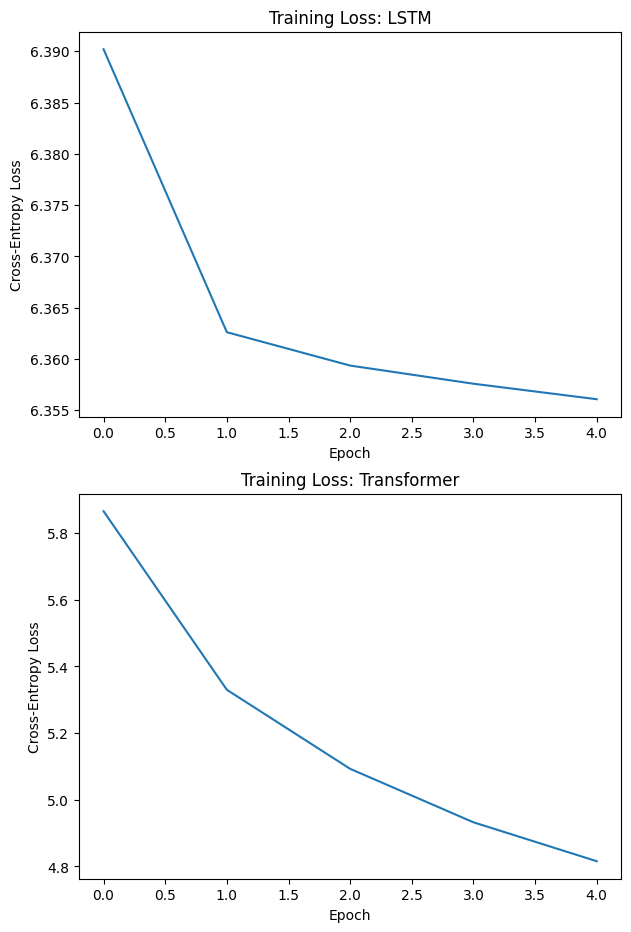

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 11))

plt.subplot(2, 1, 1)
plt.plot(lstm_train_losses, label="LSTM")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss: LSTM")

plt.subplot(2, 1, 2)
plt.plot(transformer_train_losses, label="Transformer")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss: Transformer")

plt.show()

In [12]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 103.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=96fe5e02273f3152d2028bf851b1d97f04c1c9d25fc348d1fb814818b8dd82f5
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


In [13]:
import chess

def legal_move(model):
  def board_from_san_sequence(san_moves):
      board = chess.Board()
      for san in san_moves:
          try:
              board.push_san(san)
          except:
              break
      return board

  def get_topk_predictions(model, X_seq, k=5):
      model.eval()
      with torch.no_grad():
          logits = model(X_seq)
          probs = torch.softmax(logits, dim=-1).squeeze(0)

      topk = torch.topk(probs, k)
      return [(inv_vocab[i.item()], probs[i].item()) for i in topk.indices]

  def filter_legal_moves(board, topk_preds):
      legal = []
      illegal = []

      for san, prob in topk_preds:
          try:
              move = board.parse_san(san)
              if move in board.legal_moves:
                  legal.append((san, prob))
              else:
                  illegal.append((san, prob))
          except:
              illegal.append((san, prob))

      return legal, illegal
  device = next(model.parameters()).device

  # Take one test sequence
  X_sample = X_test[0].unsqueeze(0).to(device)

  # Decode move history (remove PAD)
  san_history = [
      inv_vocab[t.item()]
      for t in X_test[0]
      if t.item() != vocab['<PAD>']
  ]

  # Build board
  board = board_from_san_sequence(san_history)

  # Get top-5 predictions
  top5 = get_topk_predictions(model, X_sample, k=5)

  # Check legality
  legal, illegal = filter_legal_moves(board, top5)

  print("\nTop-5 raw predictions:")
  for san, p in top5:
      print(f"{san:8s}  prob={p:.4f}")

  print("\nIllegal moves:")
  for san, p in illegal:
      print(f"{san:8s}")

  print("\nLegal moves:")
  for san, p in legal:
      print(f"{san:8s}")

  best_legal = legal[0][0] if legal else None
  print("\nChosen move:", best_legal)

  return best_legal



best_legal = legal_move(transformer_model)
pred_move = best_legal


Top-5 raw predictions:
O-O       prob=0.0579
Qxd7+     prob=0.0361
Rad1      prob=0.0321
Ng5       prob=0.0239
Nc3       prob=0.0227

Illegal moves:
O-O     
Rad1    

Legal moves:
Qxd7+   
Ng5     
Nc3     

Chosen move: Qxd7+


In [14]:
import chess
import chess.pgn
import urllib.parse
import webbrowser
from IPython.display import HTML, display

board = chess.Board()
game = chess.pgn.Game()
node = game
idx = 0  # First test example

def decode_sequence(x_tensor, inv_vocab, pad_id=0):
    # x_tensor: shape (seq_len,)
    moves = []
    for token_id in x_tensor.tolist():
        if token_id == pad_id:
            break
        moves.append(inv_vocab[token_id])
    return moves

san_moves = decode_sequence(X_test[idx], inv_vocab)

for san in san_moves:
    move = board.parse_san(san)
    board.push(move)
    node = node.add_variation(move)

# Now add predicted move
predicted_move = board.parse_san(pred_move)
board.push(predicted_move)
node.add_variation(predicted_move)

print(game[0])

pgn_str = str(game)
url = "https://lichess.org/analysis/pgn/" + urllib.parse.quote(pgn_str)
# print(url)

display(HTML(f'<a href="{url}" target="_blank">Open Lichess Analysis</a>'))

1. e4 e5 2. Bc4 Nc6 3. Nf3 h6 4. O-O Nf6 5. d4 Qe7 6. dxe5 Nxe4 7. Qd5 Nc5 8. Be3 b6 9. a3 d6 10. b4 Nxe5 11. bxc5 c6 12. Qxd6 Nxc4 13. Qxc6+ Qd7 14. Qxd7+
